## Install necessary Libraries.

In [84]:
!pip install spacy wordcloud tensorflow --quiet

## Install required packages.

In [85]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import spacy
import tensorflow as tf

## Ingest the data.

Read the data from the text file and store it for further processing.

In [86]:
def read_file(file_path: str):

  with open(file_path, 'r') as f:
    file_content = f.read()

  return file_content

In [ ]:
!unzip shakesphere.zip -d data

In [5]:
file_path = 'data/shakespeare.txt'
text = read_file(file_path)

## Visualize

In [6]:
def create_word_cloud(text, width=800, height=400, background_color='white', max_words=200):
    """
    Generates and displays a word cloud from the input text.

    Parameters:
    text (str): The input text to generate the word cloud from.
    width (int): Width of the word cloud image. Default is 800.
    height (int): Height of the word cloud image. Default is 400.
    background_color (str): Background color of the word cloud. Default is white.
    max_words (int): Maximum number of words to display in the word cloud. Default is 200.

    Returns:
    None (Displays the word cloud plot)
    """
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        max_words=max_words
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

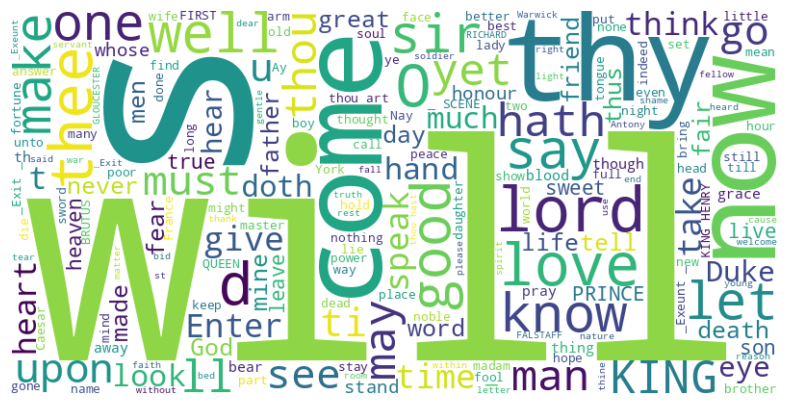

In [7]:
create_word_cloud(text)

## Text preprocessing.


Remove punctuations, unnecessary characters for Model training.

In [8]:
nlp = spacy.load('en_core_web_sm')
# nlp.max_length = 1198623

In [87]:
def process_text_in_chunks(text, chunk_size=50000) -> List[str]:
    """
    Processes the text data in chunks if the document it too large.
    parameters:
    - text: The text data.
    - chunk_size: The size of the chunk.
    returns:
    - A list of chunks.
    """
    if chunk_size is None:
      chunks = [text]
    else:
      chunks = [text[i:i+chunk_size] for i in range(0, chunk_size * 2, chunk_size)]

    docs = [nlp(chunk) for chunk in chunks]

    return docs

In [62]:
import re

In [88]:
def separate_punctuation(text: str) -> List[str]:
  """
  Removes the punctuation and preprocess the text from the words.
  parameters:
  - text: The text data.
  returns:
  - A list of tokens.
  """

  chunks = process_text_in_chunks(text)
  tokenized_text = []

  for chunk in chunks:
    # process the chunks using spacy library.
    text = nlp(chunk)

    # removes the unnecessary characters from the text.
    tokens = [re.sub(" +", " ", token.text.lower()) for token in text]
    tokens = [re.sub("[^a-z0-9]", "", token) for token in tokens]
    tokens = [token for token in tokens if token != ""]

    # add tokenized chunks to the list.
    tokenized_text.extend(tokens)

  return tokenized_text

In [89]:
tokenized_text = separate_punctuation(text)

In [92]:
# specify the input length for training.
train_len = 25 + 1

text_sequences = []
for i in range(train_len, len(tokenized_text)):

  # prepare the data for text2text generation task.
  seq = tokenized_text[i-train_len:i]
  text_sequences.append(seq)

# visualize the format of the text data.
print(f"First sentence: \n {' '.join(text_sequences[0])}")
print(f"Second sentence: \n {' '.join(text_sequences[1])}")

First sentence: 
 the project gutenberg ebook of the complete works of william shakespeare this ebook is for the use of anyone anywhere in the united states and most
Second sentence: 
 project gutenberg ebook of the complete works of william shakespeare this ebook is for the use of anyone anywhere in the united states and most other


## Tokenization.

Tokenize the text sequence in sequential manner for Model training.

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [39]:
# create a Tokenizer instance and fit on the text data.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

# get the encodings from the tokenizer.
sequences = tokenizer.texts_to_sequences(text_sequences)

# tokenizer maps words to a certain index.
sequences = np.array(sequences)
print(sequences[0])

In [43]:
# convert back the encoded sequence to words using tokenizer.index_word dict.
for i in sequences[20]:
  print(tokenizer.index_word[i], end=" ")

in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it 

## Transforming data for Training.

In [ ]:
from tensorflow.keras.utils import to_categorical

In [46]:
# use n-1 words in a sequence as features and nth word as target.
X, y = sequences[:, :-1], sequences[:, -1]

# get the total vocabulary size from the tokenizer.
vocabulary_size = len(tokenizer.word_counts)
seq_len = X.shape[1]

# encode the target variable for multi-class classification.
y = to_categorical(y, num_classes=vocabulary_size + 1)

## Model Building and Training.

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [74]:
model = Sequential(layers=[

    Embedding(input_dim=vocabulary_size+1, output_dim=seq_len),

    LSTM(units=50, return_sequences=True),
    LSTM(units=50),

    Dense(units=50, activation='relu'),
    Dense(units=vocabulary_size+1, activation='softmax')
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [77]:
model.fit(X, y, batch_size=32, epochs=200, verbose=1)

570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4348 - loss: 2.4302
Epoch 150/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4301 - loss: 2.4234
Epoch 151/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4312 - loss: 2.4060
Epoch 152/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4372 - loss: 2.3894
Epoch 153/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4272 - loss: 2.3908
Epoch 154/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4401 - loss: 2.3651
Epoch 155/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4470 - loss: 2.3520
Epoch 156/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4513 - loss: 2.3428
Epoch 157/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4505 - loss: 2.3309
Epoch 158/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4640 - loss: 2.2863
Epoch 159/200
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4558 - loss: 2.2911
Epoch 160/200

## Artifacts.

In [80]:
from pickle import dump, load

model.save("text_generation.h5")
dump(tokenizer, open('tokenizer.pkl', 'wb'))

## Prediction

In [81]:
from tensorflow.keras.utils import pad_sequences

In [82]:
def generate_text(model, tokenizer, seed_text, num_words):
  """
  Generate text using the trained model.
  params:
  - model -> Trained DL Model for text2text generation.
  - tokenizer -> Trained Tokenizer.
  - seed_text -> Seed text for text generation.
  - num_words -> Number of words to generate.
  """

  input_text = seed_text
  output_text = seed_text.split(" ")

  for _ in range(num_words):

    # encode the text using tokenizer and pad it upto correct seq length.
    encoded_text = tokenizer.texts_to_sequences([input_text])[0]
    encoded_text = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

    # predict using the model.
    predicted_word_index = np.argmax(model.predict(encoded_text, verbose=0))
    predicted_word = tokenizer.index_word[predicted_word_index]

    # update the input and output text for further generation.
    input_text += " " + predicted_word
    output_text.append(predicted_word)

  return " ".join(output_text)

In [83]:
generate_text(model, tokenizer, "shakeshphere is", 20)

'shakeshphere is be directly kill in thee resort 73 with true numbered eat wherein we see then again bearing the wanton burden'